In [1]:
%matplotlib inline  
from pymongo import MongoClient
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import math

#Ploting
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster

client = MongoClient()
congestion = client.congestion
data = congestion.coyote2
osm_rennes = client.osm
roads = osm_rennes.roads

In [2]:
def print_road(road_id):

    coords = roads.find({'_id': road_id})[0]['loc']['coordinates']

    folium_map = folium.Map(location=[48.11,-1.66],
                         zoom_start=13,
                         tiles="OpenStreetMap")
    folium.PolyLine(
        locations=[[x[1], x[0]] for x in coords],
        color='red'
    ).add_to(folium_map)

    return folium_map

In [5]:
data.count()

/home/maxime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


496410

## Investigate Data

### Points by minutes

In [11]:
aggreg = list(data.aggregate(
   [
       {"$project" : {
           "time": {"$toDate":  { "$multiply": [{ "$toLong": "$time"}, 1000] } } 
        }
      },
     {
        "$group" : {
           "_id" : {
                "month": { "$month": "$time" }, 
                "day": { "$dayOfMonth": "$time" }, 
                "hour": { "$hour": "$time" }, 
                "interval": {
                    "$subtract": [ 
                        { "$minute": "$time" },
                        { "$mod": [{ "$minute": "$time"}, 15] }
                    ]
                }
            },
           "count": { "$sum": 1 },
           "time": {"$first": "$time"}
        }
      },
      { "$sort": { "time": 1 } }
   ], allowDiskUse=True
))

In [41]:
np.sum([d['count'] for d in aggreg])

19419681

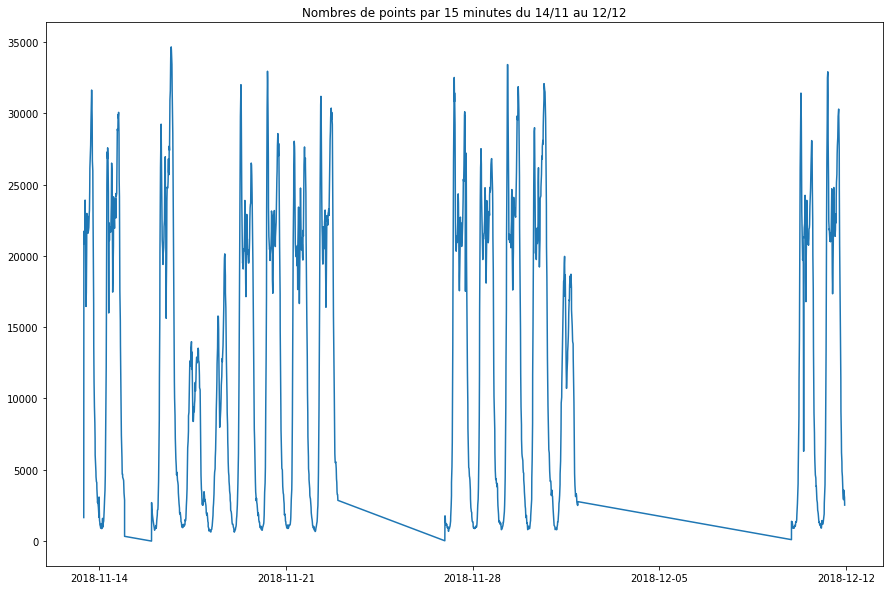

In [19]:
plt.figure(figsize=(15, 10))
plt.plot([d['time'] for d in aggreg], [d['count'] for d in aggreg])

plt.title('Nombres de points par 15 minutes du 14/11 au 12/12')
plt.savefig('points_per_15_minute.png')

### Points by 15 minutes

In [7]:
aggreg_15 = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : {
                "month": { "$month": "$time" }, 
                "day": { "$dayOfMonth": "$time" }, 
                "hour": { "$hour": "$time" }, 
                "interval": {
                    "$subtract": [ 
                        { "$minute": "$time" },
                        { "$mod": [{ "$minute": "$time"}, 15] }
                    ]
                }
            },
           "count": { "$sum": 1 },
           "time": {"$first": "$time"}
        }
      },
      { "$sort": { "time": 1 } }
   ]
))

Text(0.5, 1.0, 'Nombres de points par 15 minutes du 12/10 au 14/10')

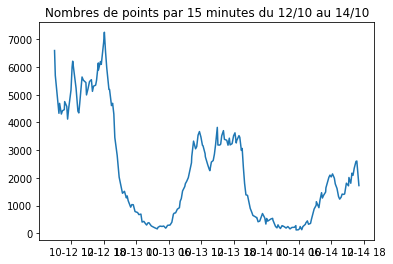

In [8]:
plt.plot([d['time'] for d in aggreg_15], [d['count'] for d in aggreg_15])
plt.title('Nombres de points par 15 minutes du 12/10 au 14/10')

### Points per day

In [14]:
aggreg_day = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : {
                "month": { "$month": "$time" }, 
                "day": { "$dayOfMonth": "$time" }, 
            },
           "count": { "$sum": 1 },
           "time": {"$first": {"$dayOfMonth": "$time"}}
        }
      },
      { "$sort": { "time": 1 } }
   ]
))

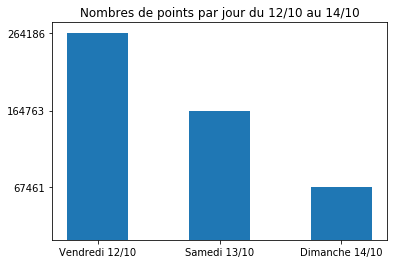

In [26]:
plt.bar([d['time'] for d in aggreg_day], [d['count'] for d in aggreg_day], width=0.5)
plt.title('Nombres de points par jour du 12/10 au 14/10')
plt.xticks([d['time'] for d in aggreg_day], ["Vendredi 12/10", "Samedi 13/10", "Dimanche 14/10"])
plt.yticks([d['count'] for d in aggreg_day], [d['count'] for d in aggreg_day])
plt.savefig('points_per_day.png')

### Cars per day

In [29]:
cars_day = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : {
                "month": { "$month": "$time" }, 
                "day": { "$dayOfMonth": "$time" },
                "id": "$id"
            },
            "time": {"$first": {"$dayOfMonth": "$time"}}
        }
      },
      {
        "$group" : {
           "_id" : {
                "day": "$time",
            },
           "count": { "$sum": 1 },
           "time": {"$first": "$time"}
        }
      },
      { "$sort": { "time": 1 } }
   ]
))

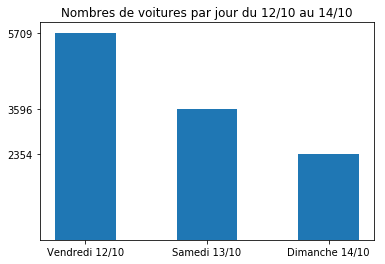

In [30]:
plt.bar([d['time'] for d in cars_day], [d['count'] for d in cars_day], width=0.5)
plt.title('Nombres de voitures par jour du 12/10 au 14/10')
plt.xticks([d['time'] for d in cars_day], ["Vendredi 12/10", "Samedi 13/10", "Dimanche 14/10"])
plt.yticks([d['count'] for d in cars_day], [d['count'] for d in cars_day])
plt.savefig('cars_per_day.png')

## Affecting the roads to points

In [2]:
from affect_road_to_point import Affect_road_to_point


In [3]:
affect = Affect_road_to_point(data, roads, 10)    
affect.affect()

490000 points modified
Done.
496410 points modified / 496410 in 696.303 seconds


986 secs to match 496410 points with the serial algorithm

692 secs with bulk algorithm 1000 requests bulks

In [1]:
from affect_road_to_point_para import Affect_road_to_point

In [2]:
db_name, collection_name, db_osm_name, roads_name = "geo4cast", "coyote_data_rennes", "osm-rennes", "roads"
affect = Affect_road_to_point( db_name, collection_name, db_osm_name, roads_name, 10)

In [3]:
%%time
affect.affect_para(4)

Worker 3 done: 124101 points modified24103
Worker 1 done: 124103 points modified
Worker 2 done: 124103 points modified
Worker 0 done: 124103 points modified
Done in 246.032 seconds
CPU times: user 118 ms, sys: 42.5 ms, total: 161 ms
Wall time: 4min 6s


In [8]:
%%time
affect.affect_para(4)

/home/maxime/.local/lib/python3.6/site-packages/pymongo/topology.py:149: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/home/maxime/.local/lib/python3.6/site-packages/pymongo/topology.py:149: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/home/maxime/.local/lib/python3.6/site-packages/pymongo/topology.py:149: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/home/maxime/.local

Worker 3 done: 124101 points modified
Worker 1 done: 124103 points modified
Worker 0 done: 124103 points modified
Worker 2 done: 124103 points modified
Done in 255.805 seconds
CPU times: user 83 ms, sys: 77.2 ms, total: 160 ms
Wall time: 4min 15s


In [9]:
data.find({"matching_road": ""}).count()

/home/maxime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


25487

In [4]:
affect.affect_para(4)

Worker 0 : 1000 points modified
Worker 1 : 1000 points modified
Worker 3 : 1000 points modified
Worker 2 : 1000 points modified
Worker 0 : 2000 points modified
Worker 1 : 2000 points modified
Worker 2 : 2000 points modified
Worker 3 : 2000 points modified
Worker 0 : 3000 points modified
Worker 1 : 3000 points modified
Worker 2 : 3000 points modified
Worker 3 : 3000 points modified
Worker 1 : 4000 points modified
Worker 2 : 4000 points modified
Worker 0 : 4000 points modified
Worker 3 : 4000 points modified
Worker 1 : 5000 points modified
Worker 2 : 5000 points modified
Worker 0 : 5000 points modified
Worker 3 : 5000 points modified
Worker 1 : 6000 points modified
Worker 2 : 6000 points modified
Worker 3 : 6000 points modified
Worker 0 : 6000 points modified
Worker 1 : 7000 points modified
Worker 2 : 7000 points modified
Worker 3 : 7000 points modified
Worker 0 : 7000 points modified
Worker 1 : 8000 points modified
Worker 2 : 8000 points modified
Worker 3 : 8000 points modified
Worker 0

## Investigating the roads

### Roads with the most points

In [23]:
import sys
sys.path.append('../scripts/')
sys.path.append('../source/')

import OsmProcessing

segments=OsmProcessing.getSegments(client['osm'].roads)
roads_ids = segments.index.values.tolist()

In [37]:
mp25[0]

466806125

In [38]:
aggreg_roads = list(data.aggregate(
   [
        {"$match":{"matching_road" :{"$in": mp25 }}},
      {
        "$group" : {
           "_id" : {
                "matchingRoad": "$matching_road"
            },
           "count": { "$sum": 1 }
        }
      },
      { "$sort": { "count": -1 } }
   ]
))

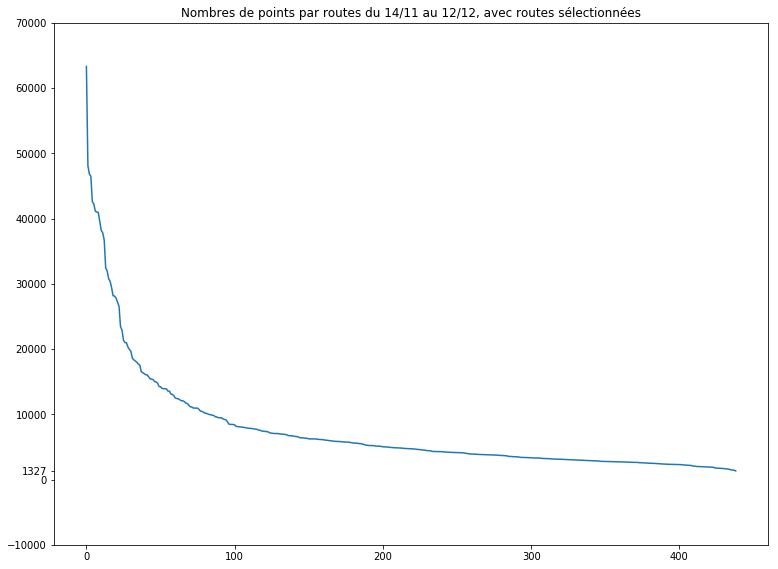

In [40]:
plt.figure(figsize=(12.8, 9.6))
plt.plot([d['count'] for d in aggreg_roads[1:]])
plt.yticks(list(plt.yticks()[0]) + [aggreg_roads[-1]['count']])
plt.title('Nombres de points par routes du 14/11 au 12/12, avec routes sélectionnées')
plt.savefig("points_per_road_relevant2.png")

In [22]:
len(aggreg_roads)

61515

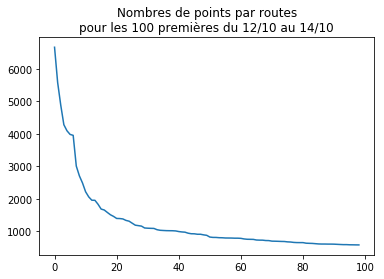

In [119]:
plt.plot([d['count'] for d in aggreg_roads[1:100]])
plt.title('Nombres de points par routes\npour les 100 premières du 12/10 au 14/10')
plt.savefig("points_per_100road.png")

In [17]:
print("Route avec le plus de points:", aggreg_roads[1]['_id']['matchingRoad'], "avec", aggreg_roads[1]['count'], "points")

Route avec le plus de points: 30724372 avec 6659 points


In [16]:
print("Points trop loin des routes (donc non affectés):", aggreg_roads[0]['count'])

Points trop loin des routes (donc non affectés): 25487


In [18]:
print("Moyenne de points par route:", np.mean([d['count'] for d in aggreg_roads[1:]]))

Moyenne de points par route: 64.11477195371


In [19]:
print("Nombre de routes avec 10 points ou moins:", len([d['count'] for d in aggreg_roads[1:] if d['count'] < 11]))

Nombre de routes avec 10 points ou moins: 3104


In [22]:
print("Nombre de routes avec 100 points ou plus:", len([d['count'] for d in aggreg_roads[1:] if d['count'] > 99]))

Nombre de routes avec 100 points ou plus: 1099


In [93]:
coords = roads.find({'_id': 4999805})[0]['loc']['coordinates']

In [102]:
folium_map = folium.Map(location=[48.11,-1.66],
                         zoom_start=13,
                         tiles="OpenStreetMap")
folium.PolyLine(
    locations=[[x[1], x[0]] for x in coords],
    color='red'
).add_to(folium_map)

folium_map

In [6]:
print_road(4999805)

In [ ]:
Stats par jour, nombre de voitures/jour, 

In [109]:
aggreg_roads_class = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : {
                "matchingRoad": "$matching_road"
            },
           "count": { "$sum": 1 }
        }
      },
      {
        "$group" : {
           "_id" : {
                "class": { 
                    "$trunc": [
                        {"$log10": "$count"}
                        ]
                    }
            },
           "count": { "$sum": 1 }
        }
      },
      { "$sort": { "count": -1 } }
   ]
))[:-1]

In [110]:
len([d['count'] for d in aggreg_roads_class])

4

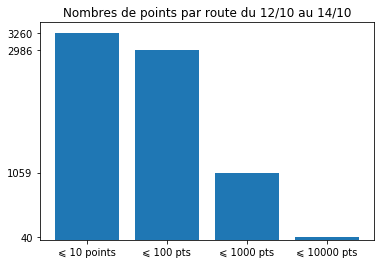

In [111]:
plt.bar(np.arange(4), [d['count'] for d in aggreg_roads_class])
plt.title('Nombres de points par route du 12/10 au 14/10')
plt.xticks(np.arange(4), ["⩽ 10 points", "⩽ 100 pts","⩽ 1000 pts","⩽ 10000 pts"])
plt.yticks([d['count'] for d in aggreg_roads_class], [d['count'] for d in aggreg_roads_class])
plt.savefig('points_per_road_aggreg.png')

In [91]:
aggreg_roads_cars = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : {
                "matchingRoad": "$matching_road",
                "id": "$id"
            },
            "matching_road": {"$first": "$matching_road"}
        }
      },
      {
        "$group" : {
           "_id" : {
                "matchingRoad": "$matching_road"
            },
           "count": { "$sum": 1 }
        }
      },
      { "$sort": { "count": -1 } }
   ]
))

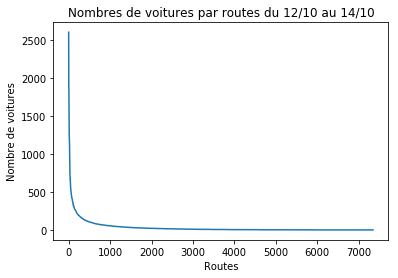

In [101]:
plt.plot([d['count'] for d in aggreg_roads_cars])
plt.title('Nombres de voitures par routes du 12/10 au 14/10')
plt.xlabel("Routes")
plt.ylabel("Nombre de voitures")
plt.savefig('cars_per_road.png')

In [112]:
aggreg_roads_cars_class = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : {
                "matchingRoad": "$matching_road",
                "id": "$id"
            },
            "matching_road": {"$first": "$matching_road"}
        }
      },
      {
        "$group" : {
           "_id" : {
                "matchingRoad": "$matching_road"
            },
           "count": { "$sum": 1 }
        }
      },
       {
        "$group" : {
           "_id" : {
                "class": { 
                    "$trunc": [
                        {"$log10": "$count"}
                        ]
                    }
            },
           "count": { "$sum": 1 }
        }
      },
      { "$sort": { "count": -1 } }
   ]
))

In [113]:
pprint(aggreg_roads_cars_class)

[{'_id': {'class': 0.0}, 'count': 4285},
 {'_id': {'class': 1.0}, 'count': 2523},
 {'_id': {'class': 2.0}, 'count': 515},
 {'_id': {'class': 3.0}, 'count': 23}]


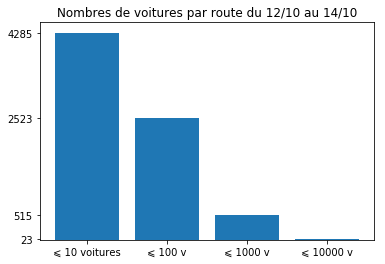

In [115]:
plt.bar(np.arange(4), [d['count'] for d in aggreg_roads_cars_class])
plt.title('Nombres de voitures par route du 12/10 au 14/10')
plt.xticks(np.arange(4), ["⩽ 10 voitures", "⩽ 100 v","⩽ 1000 v","⩽ 10000 v"])
plt.yticks([d['count'] for d in aggreg_roads_cars_class], [d['count'] for d in aggreg_roads_cars_class])
plt.savefig('cars_per_road_aggreg.png')

### Speeds

In [137]:
avg_speed = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : "null",
            "avg_speed": {"$avg": "$speed"}
        }
      },
      { "$sort": { "avg_speed": 1 } }
   ]
))[0]["avg_speed"]

In [138]:
print("Average speed:", avg_speed)

Average speed: 32.97333857093935


In [139]:
avg_speed_per_day = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : {"day": {"$dayOfMonth": "$time"}},
            "avg_speed": {"$avg": "$speed"}
        }
      },
      { "$sort": { "avg_speed": 1 } }
   ]
))

In [143]:
for e in avg_speed_per_day:
    print("Average speed on the",e["_id"]["day"] ,"\bth:", e["avg_speed"])

Average speed on the 12th: 31.085322462204658
Average speed on the 13th: 33.04119250074349
Average speed on the 14th: 40.201331139473176


In [120]:
avg_speed = list(data.aggregate(
   [
      {
        "$group" : {
           "_id" : {
                "matchingRoad": "$matching_road",
                "day": {"$dayOfMonth": "$time"}
            },
            "avg_speed": {"$avg": "$speed"}
        }
      },
      { "$sort": { "avg_speed": 1 } }
   ]
))

In [122]:
pprint(avg_speed)

[{'_id': {'day': 13, 'matchingRoad': 173565827}, 'avg_speed': 0.0},
 {'_id': {'day': 13, 'matchingRoad': 160536067}, 'avg_speed': 0.0},
 {'_id': {'day': 13, 'matchingRoad': 205702740}, 'avg_speed': 0.0},
 {'_id': {'day': 13, 'matchingRoad': 224158614}, 'avg_speed': 0.0},
 {'_id': {'day': 12, 'matchingRoad': 65729188}, 'avg_speed': 0.0},
 {'_id': {'day': 14, 'matchingRoad': 551855381}, 'avg_speed': 0.0},
 {'_id': {'day': 12, 'matchingRoad': 28010154}, 'avg_speed': 0.0},
 {'_id': {'day': 13, 'matchingRoad': 30037099}, 'avg_speed': 0.0},
 {'_id': {'day': 13, 'matchingRoad': 30086359}, 'avg_speed': 0.0},
 {'_id': {'day': 12, 'matchingRoad': 30085943}, 'avg_speed': 0.0},
 {'_id': {'day': 12, 'matchingRoad': 346010419}, 'avg_speed': 0.0},
 {'_id': {'day': 12, 'matchingRoad': 30085931}, 'avg_speed': 0.0},
 {'_id': {'day': 13, 'matchingRoad': 345994450}, 'avg_speed': 0.0},
 {'_id': {'day': 14, 'matchingRoad': 30085929}, 'avg_speed': 0.0},
 {'_id': {'day': 13, 'matchingRoad': 29694588}, 'avg_sp

In [9]:
done = False
rocade_roads=[30724372]
last_point= [-1.6300494, 48.0901668]
while not done:
    #find next road ie find where loc[coordinates][0] == locprv[coordinates][-1]
    next_road = roads.find_one({"loc.coordinates.0": last_point, "key": {"$not": {"$in": ["link"]}}}, {"_id":1, "loc.coordinates":1})
    #print(next_road)
    last_point = next_road['loc']['coordinates'][-1]
    if next_road['_id'] == rocade_roads[0]:
        break
    rocade_roads.append(next_road['_id'])
    print(rocade_roads)


[30724372, 22820651]
[30724372, 22820651, 22820652]
[30724372, 22820651, 22820652, 15530312]
[30724372, 22820651, 22820652, 15530312, 15530313]
[30724372, 22820651, 22820652, 15530312, 15530313, 217182348]
[30724372, 22820651, 22820652, 15530312, 15530313, 217182348, 217182347]
[30724372, 22820651, 22820652, 15530312, 15530313, 217182348, 217182347, 466546390]
[30724372, 22820651, 22820652, 15530312, 15530313, 217182348, 217182347, 466546390, 222139156]
[30724372, 22820651, 22820652, 15530312, 15530313, 217182348, 217182347, 466546390, 222139156, 466760891]
[30724372, 22820651, 22820652, 15530312, 15530313, 217182348, 217182347, 466546390, 222139156, 466760891, 221776707]
[30724372, 22820651, 22820652, 15530312, 15530313, 217182348, 217182347, 466546390, 222139156, 466760891, 221776707, 289704905]
[30724372, 22820651, 22820652, 15530312, 15530313, 217182348, 217182347, 466546390, 222139156, 466760891, 221776707, 289704905, 5037445]
[30724372, 22820651, 22820652, 15530312, 15530313, 217

TypeError: 'NoneType' object is not subscriptable

## Agregattting using headings

In [68]:
roads_with_headings = list(data.aggregate([
       {
        "$group" : {
          "_id" : {
              "matchingRoad": "$matching_road"
           },
          "headings": { "$push": "$heading"},
          "count": { "$sum": 1 } 
        }
       },
       {"$sort": {"count": -1}}
    ]))


In [70]:
roads_with_headings[3]

{'_id': {'matchingRoad': 4999805},
 'count': 4877,
 'headings': [349,
  350,
  349,
  350,
  350,
  348,
  349,
  353,
  350,
  349,
  350,
  349,
  349,
  350,
  351,
  351,
  349,
  350,
  349,
  351,
  333,
  348,
  351,
  349,
  349,
  348,
  354,
  350,
  348,
  349,
  349,
  348,
  349,
  345,
  349,
  339,
  349,
  349,
  349,
  349,
  349,
  350,
  348,
  349,
  348,
  347,
  345,
  349,
  349,
  348,
  348,
  349,
  349,
  352,
  327,
  348,
  351,
  327,
  354,
  344,
  350,
  0,
  0,
  348,
  348,
  348,
  348,
  348,
  350,
  349,
  349,
  349,
  349,
  350,
  349,
  349,
  349,
  346,
  349,
  348,
  349,
  349,
  349,
  349,
  350,
  350,
  350,
  349,
  350,
  349,
  349,
  349,
  349,
  348,
  349,
  349,
  349,
  349,
  349,
  348,
  349,
  348,
  348,
  349,
  349,
  349,
  348,
  349,
  349,
  347,
  348,
  348,
  349,
  346,
  348,
  349,
  350,
  347,
  348,
  350,
  348,
  349,
  347,
  350,
  349,
  351,
  349,
  346,
  347,
  348,
  346,
  347,
  349,
  345,
  3

In [91]:
np.where(kmeans.labels_ == 1)[0]

array([  61,   62,  697,  698,  699,  744,  926,  932, 1573, 1589, 1899,
       1969, 2048, 2232, 2883, 3270, 3314, 3519, 3558, 3560, 3659, 3743,
       4054, 4293, 4446])

In [92]:
[roads_with_headings[3]['headings'][k] for k in np.where(kmeans.labels_ == 1)[0]]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 158,
 158,
 0,
 164,
 0,
 0,
 0,
 0,
 138,
 0,
 0,
 0,
 138,
 0,
 140,
 0]

<BarContainer object of 360 artists>

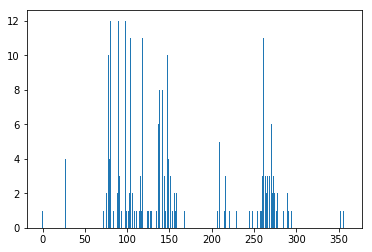

In [41]:
counts=np.zeros(360)
for h in roads_with_headings[0]['headings']:
    counts[h['heading']]=h['count']
plt.bar(np.arange(360), counts)

In [71]:
headings = roads_with_headings[3]['headings']
headings = np.array(headings)
headings = headings.reshape(-1,1)

In [72]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(headings)

In [73]:
headings.shape

(4877, 1)

In [74]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [75]:
kmeans.cluster_centers_

array([[330.21846661],
       [ 35.84      ]])

### How to get the headings
- get the headings with the counts
- transform to array with with shape (count, 1) => headings.reshape(-1,1)
- fit Kmeans (2 clusters) => kmeans = KMeans(n_clusters=2, random_state=0).fit(headings)
- get the lebels => kmeans.labels\_
- if neeeded get the centers => kmeans.cluster\_centers\_

In [24]:
print_road(9363031)

In [38]:
shape1 = roads.find_one({"_id":7979548})['loc']['coordinates']
shape1

[[-1.6778236, 48.1110034], [-1.6778204, 48.1117365]]

In [39]:
math.degrees(math.atan2((shape1[-1][0] - shape1[0][0]),(shape1[-1][1] - shape1[0][1])))

0.25009593505311883

In [27]:
r = roads.find_one({"_id":9363031})

In [25]:
shape = r['loc']['coordinates']
shape

[[-1.6778236, 48.1110034],
 [-1.6778211, 48.110852],
 [-1.6778305, 48.1102459],
 [-1.6778321, 48.1101814]]

In [36]:
math.degrees(math.atan2((shape[-1][0] - shape[0][0]),(shape[-1][1] - shape[0][1])))

-179.40754651047857

In [45]:
r_with_headings = list(data.aggregate([
       {
        "$group" : {
          "_id" : {
              "matchingRoad": "$matching_road"
           },
          "headings": { "$push": "$heading"},
          "count": { "$sum": 1 } 
        }
       },
       { "$match" : { "_id.matchingRoad" : 460117031 } }
    ]))

In [42]:
r_with_headings

[{'_id': {'matchingRoad': 8101374},
  'count': 221,
  'headings': [51,
   34,
   52,
   51,
   39,
   42,
   46,
   57,
   34,
   99,
   99,
   48,
   99,
   63,
   50,
   41,
   99,
   48,
   99,
   299,
   292,
   67,
   1,
   41,
   41,
   41,
   41,
   41,
   311,
   41,
   41,
   41,
   41,
   59,
   49,
   46,
   54,
   68,
   29,
   29,
   58,
   56,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   27,
   315,
   315,
   315,
   315,
   81,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   324,
   47,
   0,
   0,
   47,
   81,
   81,
   324,
   0,
   54,
   57,
   45,
   81,
   81,
   81,
   58,
   81,
   50,
   47,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   81,
   46,
   46,
   6

(array([ 2.,  0.,  1.,  0., 11., 20.,  0.,  1.,  0.,  0.,  7.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 18.]),
 array([  0.        ,   5.91666667,  11.83333333,  17.75      ,
         23.66666667,  29.58333333,  35.5       ,  41.41666667,
         47.33333333,  53.25      ,  59.16666667,  65.08333333,
         71.        ,  76.91666667,  82.83333333,  88.75      ,
         94.66666667, 100.58333333, 106.5       , 112.41666667,
        118.33333333, 124.25      , 130.16666667, 136.08333333,
        142.        , 147.91666667, 153.83333333, 159.75      ,
        165.66666667, 171.58333333, 177.5       , 183.41666667,
        189.33333333, 195.25      , 201.16666667, 207.08333333,
        213.        ]),
 <a list of 36 Patch objects>)

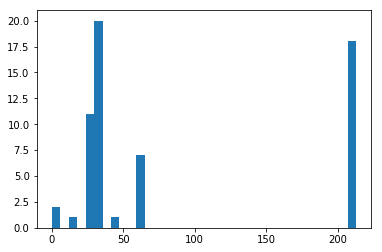

In [47]:
plt.hist(r_with_headings[0]['headings'], bins = 36)